In [ ]:
import minio
import os
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import intel_extension_for_pytorch as ipex
from ultralytics import YOLO

minio_client = minio.Minio(
    os.environ['MINIO_ENDPOINT'],
    access_key=os.environ['MINIO_ACCESS_KEY'],
    secret_key=os.environ['MINIO_SECRET_KEY'],
    secure=False
)

[W319 22:00:56.594543549 OperatorEntry.cpp:154] Warning: Warning only once for all operators,  other operators may also be overridden.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::_validate_compressed_sparse_indices(bool is_crow, Tensor compressed_idx, Tensor plain_idx, int cdim, int dim, int nnz) -> ()
    registered at /pytorch/build/aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: XPU
  previous kernel: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:30477
       new kernel: registered at /build/intel-pytorch-extension/build/Release/csrc/gpu/csrc/aten/generated/ATen/RegisterXPU.cpp:468 (function operator())


[W319 22:00:57.199741567 OperatorEntry.cpp:154] Warning: Warning only once for all operators,  other operators may also be overridden.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::_validate_compressed_sparse_indices(bool is_crow, Tensor compressed_idx, Tensor plain_idx, int cdim, int dim, int nnz) -> ()
    registered at /pytorch/build/aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: XPU
  previous kernel: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:30477
       new kernel: registered at /build/intel-pytorch-extension/build/Release/csrc/gpu/csrc/aten/generated/ATen/RegisterXPU.cpp:468 (function operator())


In [2]:
class MultiCam:
    def __init__(self, video_list):
        self.video_list = video_list
        self.cap_list: list[cv.VideoCapture] = []
        for video in video_list:
            self.cap_list.append(cv.VideoCapture(video))
        self.frame_count = [int(cap.get(cv.CAP_PROP_FRAME_COUNT)) for cap in self.cap_list]

    def seek(self, frame, sync=True):
        max_frame = max(self.frame_count)
        if frame > max_frame:
            print('Frame number exceeds the max frame count')
            return

        if sync:
            for idx, cap in enumerate(self.cap_list):
                frame_diff = max_frame - self.frame_count[idx]
                if frame_diff > 0:
                    frame_diff -= 1
                cap.set(cv.CAP_PROP_POS_FRAMES, frame - frame_diff)

        else:            
            for cap in self.cap_list:                
                if frame > self.frame_count[self.cap_list.index(cap)]:
                    print('Frame number exceeds the total frame count')
                    return
                cap.set(cv.CAP_PROP_POS_FRAMES, frame)

    def get_frame(self, frame):
        self.seek(frame)
        frame_list = []
        for cap in self.cap_list:
            ret, frame = cap.read()
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            frame_list.append(frame)
        return frame_list

    def release(self):
        for cap in self.cap_list:
            cap.release()

resolution = (1920 *0.5, 1080 *0.5)

def plot_frame(frame_list, height=10, landscape=False):
    # Plot 3 images side by side without axis and any gap between them
    if landscape:
        fig, ax = plt.subplots(1, len(frame_list),figsize=(height*resolution[0]/resolution[1]*3.1, height))
    else:
        fig, ax = plt.subplots(len(frame_list), 1, figsize=(height*resolution[0]/resolution[1], height*3))
    for idx, frame in enumerate(frame_list):
        ax[idx].imshow(frame)
        ax[idx].axis('off')
        ax[idx].set_aspect('auto')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
    fig.tight_layout()
    plt.show()

In [3]:
bucket = 'highjump'
path = 'raw_data/2025/03/18/run13/'
download_path = 'data/videos/'

video_list = list(minio_client.list_objects(bucket, path))

for video in video_list:
    minio_client.fget_object(bucket, video.object_name, download_path + video.object_name.split('/')[-1])

[6152, 6149, 6155]


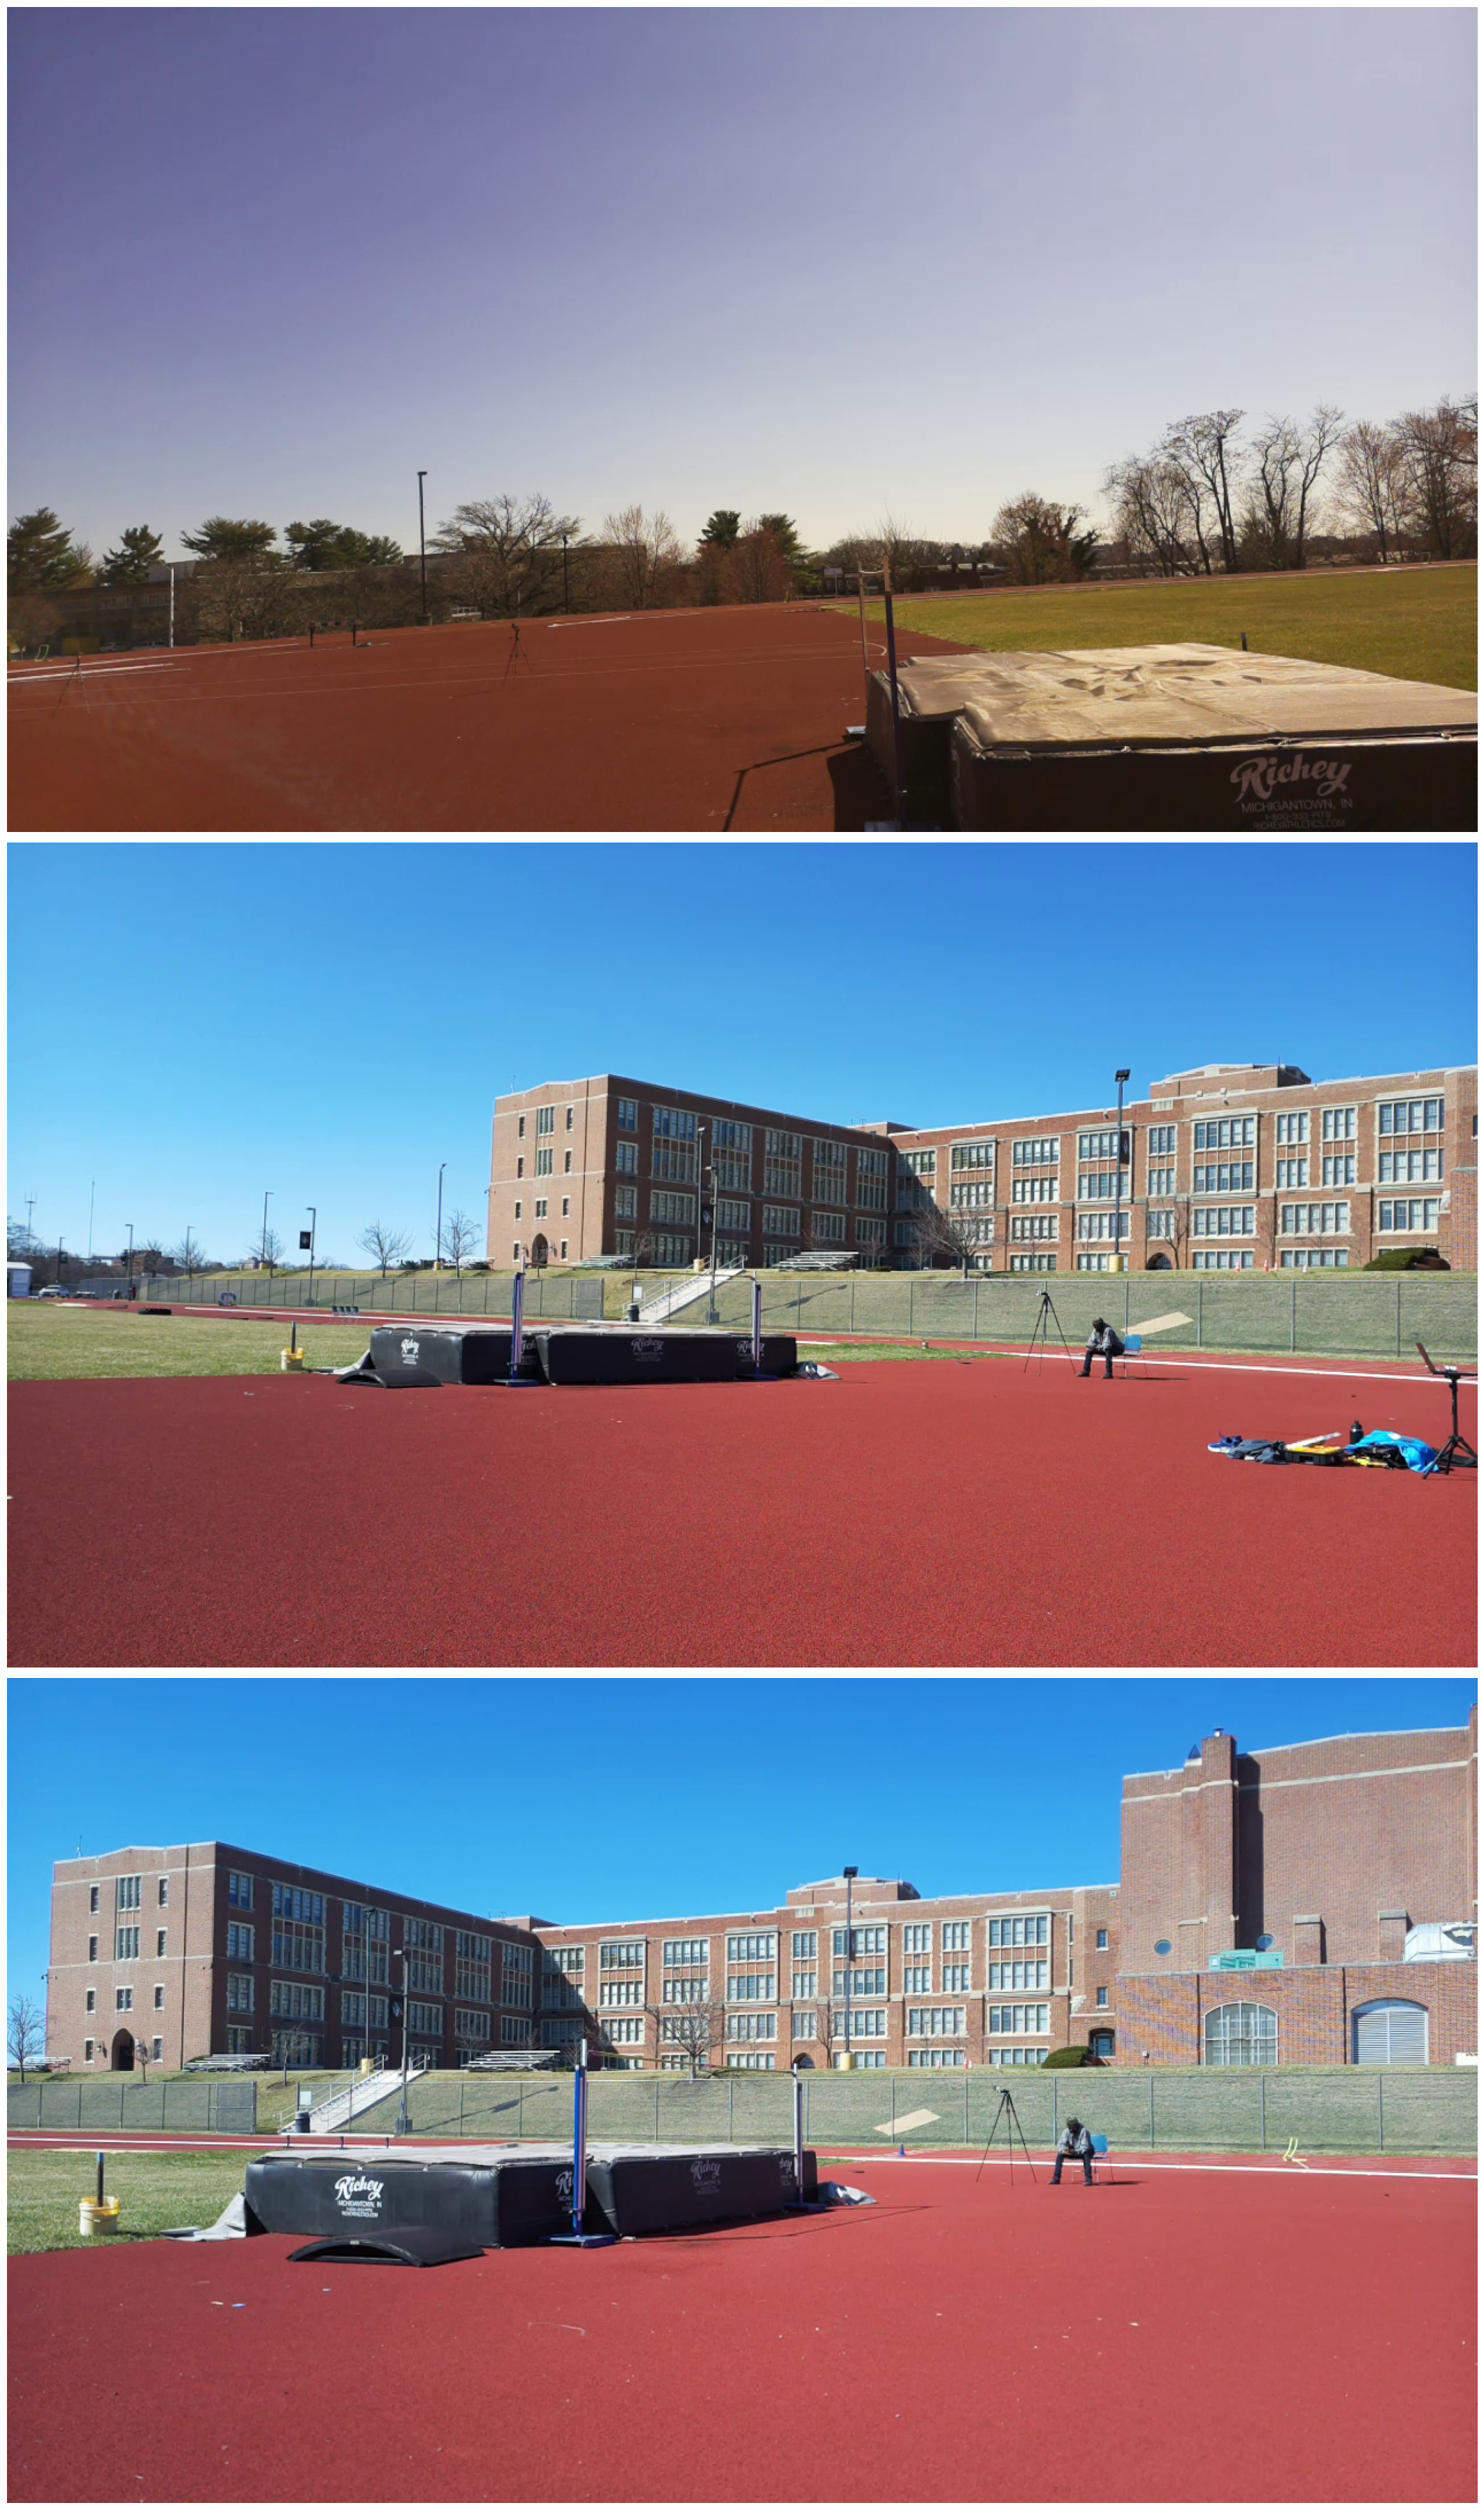

In [5]:
multi_cam = MultiCam([download_path + 'sidecam.mp4', download_path + 'curvecam.mp4', download_path + 'curvecam2.mp4'])

print(multi_cam.frame_count)
frame_list_1 = multi_cam.get_frame(3865)
plot_frame(frame_list_1, 12,landscape=False)

In [10]:
cv.imwrite('frame1.jpg', cv.cvtColor(frame_list_1[0], cv.COLOR_BGR2RGB))
cv.imwrite('frame2.jpg', cv.cvtColor(frame_list_1[1], cv.COLOR_BGR2RGB))
cv.imwrite('frame3.jpg', cv.cvtColor(frame_list_1[2], cv.COLOR_BGR2RGB))

True